In [1]:
%cd ../

/Users/harrysonghurst/Documents/Coursework/L48 Machine Learning and the Physical World/TrafficEmu


In [2]:
# If you get a SciPy error when installing Emukit, build it from source:

# git clone https://github.com/amzn/Emukit.git
# cd Emukit
# pip install -r requirements/requirements.txt
# python setup.py develop

In [3]:
import numpy as np
import pickle
import emukit as ek
import GPy

from emukit.model_wrappers import GPyModelWrapper
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs import RandomDesign, latin_design
from emukit.experimental_design.acquisitions import ModelVariance, IntegratedVarianceReduction
from emukit.core.loop import UserFunctionWrapper
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.core.optimization import GradientAcquisitionOptimizer

from sumo_grid_simulation.grid_simulation import Simulator
import experimental_design.config as config

### Pseudocode

Fitting a gaussian process to a simulator using Emukit takes the following form (taken from L48 lectures):

```
initialize GP with some randomly chosen points
while stopping condition is not met:
    compute candidate point(s) using GP and acquisition funciton (model_variance) -> new point
    evaluate this new point with our simulator/user function -> observation
    update model with new observation -> new GP
```

### Simulator

In [4]:
simulator = Simulator(end_time=300)

### User Function
 
This is the function we want to understand. Namedly, how are CO2 emissions and timeLoss (the time lost due to driving below the ideal speed) affected by the following parameters: 

```
gridSize: the size of the grid network where the simulation is carried out
edgeMaxSpeed: legal speed limit in m/s - this can be exceeded (11.11 == 40km/h)
maxSpeed: the absolute maximum velocity of any vehicle in m/s (55.55 == 200 km/h)
edgeLength: length of the roads between intersections in meters
numLanes: number of lanes per road
accel: The acceleration ability of vehicles in m/s^2.
```

*A complete list of parmeters analysed is discussed in our report.*

In [20]:
mses = []
def evaluate_model():
    pred_Y, pred_Y_variance = emukit_model_ird.predict(np.array(test_X))
    rmse = np.sqrt(np.mean((pred_Y-test_Y)**2))
    mses.append((len(Xs), rmse))
    print('EVALUATED: ', len(Xs), rmse)

In [21]:
Xs = []
Ys = []

def user_function_time_loss(X):
    """  X = inputs - emukit doesnt pass named args, just an NxM ndarray, N is the number of points to evaluate, M is the number of parameters per each point """
    result = []
    i = 0
    
    print(X)
    print(f'\nUser function time loss called with {X.shape[0]} inputs to simulate')

    
    for gridSize, edgeMaxSpeed, maxSpeed, edgeLength, numLanes, accel in X:
        print(f'\nEvaluating input: {i+1} of {X.shape[0]}\n')
        
        alpha = 0.005
        max_number_of_vehicles = ((gridSize - 1) * gridSize * 2 + 4 * gridSize) * edgeLength / 5
        period = 300/(max_number_of_vehicles * alpha)
        
        s = simulator.simulate(
            gridSize      = int(gridSize),
            edgeMaxSpeed  = edgeMaxSpeed,
            maxSpeed      = maxSpeed,
            edgeLength    = edgeLength,
            numberOfLanes = int(numLanes),
            accel         = accel,
            trips_generator_period = period
        )
        # average time loss / average route duration
        result.append(s['timeLoss']/s['duration'])
        Xs.append([int(gridSize), edgeMaxSpeed, maxSpeed, edgeLength, int(numLanes), accel])
        Ys.append(s['timeLoss']/s['duration'])
        i += 1
    
    if len(Xs) % 50 == 0:
        evaluate_model()
        
    # expand dims is essential or the acquition function breaks
    return np.expand_dims(np.array(result), 1)  

### Model Inputs / parameter space

In [14]:
parameter_space = config.get_parameter_space()

### Get init, test, and train points

Train points are used to optimize a GP without experimental design - to verify experimental design works.

In [10]:
design = RandomDesign(parameter_space)
init_X = design.get_samples(20)
init_Y = user_function_time_loss(init_X)

design = RandomDesign(parameter_space)
test_X = design.get_samples(100)
test_Y = user_function_time_loss(test_X)

design = RandomDesign(parameter_space)
train_X = design.get_samples(1020)
train_Y = user_function_time_loss(train_X)

[[ 4.         16.03308636 13.72811056 43.49902675  1.          4.24446654]
 [ 7.         12.08476129 25.10993694 40.75897301  1.          2.57456482]
 [ 6.         22.45050945 18.39483775 58.52716551  1.          3.25475037]
 [16.         21.54447762 10.34024068 31.80298547  3.          4.11882192]
 [13.         22.14355289 17.49179798 40.09662061  2.          2.18951038]
 [ 5.         23.37621902 11.67238355 54.70330593  2.          3.91768865]
 [20.         20.64924476  5.22025329 64.46077556  3.          4.78814249]
 [ 4.         20.36929928 25.92485952 54.70804205  2.          2.38762743]
 [ 8.         19.35767256 25.07243606 59.86151066  2.          3.33995615]
 [ 7.         11.0947782   7.49364524 36.51667839  1.          2.58839842]
 [ 3.         13.08009785 18.3929964  55.27077653  3.          1.7051187 ]
 [17.         21.61772332 15.28246065 45.09026534  3.          3.21892696]
 [19.         18.81149431 14.49756745 54.15955819  1.          3.631887  ]
 [ 6.         17.48625693

 Retrying in 1 seconds

Evaluating input: 2 of 100

 Retrying in 1 seconds

Evaluating input: 3 of 100

 Retrying in 1 seconds

Evaluating input: 4 of 100

 Retrying in 1 seconds

Evaluating input: 5 of 100

 Retrying in 1 seconds

Evaluating input: 6 of 100

 Retrying in 1 seconds

Evaluating input: 7 of 100

 Retrying in 1 seconds

Evaluating input: 8 of 100

 Retrying in 1 seconds

Evaluating input: 9 of 100

 Retrying in 1 seconds

Evaluating input: 10 of 100

 Retrying in 1 seconds

Evaluating input: 11 of 100

 Retrying in 1 seconds

Evaluating input: 12 of 100

 Retrying in 1 seconds

Evaluating input: 13 of 100

 Retrying in 1 seconds

Evaluating input: 14 of 100

 Retrying in 1 seconds

Evaluating input: 15 of 100

 Retrying in 1 seconds

Evaluating input: 16 of 100

 Retrying in 1 seconds

Evaluating input: 17 of 100

 Retrying in 1 seconds

Evaluating input: 18 of 100

 Retrying in 1 seconds

Evaluating input: 19 of 100

 Retrying in 1 seconds

Evaluating input: 20 of 100

 

### Experimental Design - Model Variance

#### Model / Emulator (GP)

Our surrogate model is our emulator. In this case, a gaussian process.

In [22]:
emulator_ed = GPy.models.GPRegression(init_X, init_Y)
emukit_model_ed = GPyModelWrapper(emulator_ed, n_restarts=5)
emukit_model_ed.optimize()
emulator_ed

Optimization restart 1/5, f = 4.930557731983265
Optimization restart 2/5, f = 4.930557616464668
Optimization restart 3/5, f = 4.93055549201801
Optimization restart 4/5, f = 4.930557381645391
Optimization restart 5/5, f = 4.930557734150794


GP_regression.,value,constraints,priors
rbf.variance,0.044319242653136706,+ve,
rbf.lengthscale,1.2387022238013332,+ve,
Gaussian_noise.variance,0.051545047472573116,+ve,


#### Acquisition Function

In [23]:
model_variance = ModelVariance(model=emukit_model_ed)

#### Optimizer

In [24]:
optimizer = GradientAcquisitionOptimizer(parameter_space)


#### Experimental Design Loop

In [25]:
ed_loop = ExperimentalDesignLoop(
    model = emukit_model_ed,
    space = parameter_space,
    acquisition = model_variance,
    acquisition_optimizer = optimizer,
    batch_size = 1
)

In [26]:
ed_loop.run_loop(user_function_time_loss, 1000)

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = -13.81005411632534
Optimization restart 2/5, f = 4.930557734033778
Optimization restart 3/5, f = 4.930557532365199
Optimization restart 4/5, f = 4.930557734151211
Optimization restart 5/5, f = 4.930557734150852
[[20.   8.  27.  30.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -17.419293569690183
Optimization restart 2/5, f = 5.064114627950872
Optimization restart 3/5, f = 5.064114627950879
Optimization restart 4/5, f = 5.064114627950866
Optimization restart 5/5, f = 5.064114627950879
[[ 3.   8.   5.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -18.68428852875229
Optimization restart 2/5, f = -18.077817989358394
Optimization restart 3/5, f = 4.844073756711177
Optimization restart 4/5, f = 4.844080704760536
Optimization restart 5/5, f = 4.844080

KeyboardInterrupt: 

### Experimental Design - Integrated Variance Reduction

#### Model / Emulator (GP)

In [27]:
emulator_ird = GPy.models.GPRegression(init_X, init_Y)
emukit_model_ird = GPyModelWrapper(emulator_ird, n_restarts=5)
emukit_model_ird.optimize()

Optimization restart 1/5, f = 4.930557731983265
Optimization restart 2/5, f = 4.930548160936471
Optimization restart 3/5, f = 4.930557734151472
Optimization restart 4/5, f = -16.201224237074044
Optimization restart 5/5, f = 4.9305577341506694


#### Acquisition Function

In [28]:
integrated_variance_reduction = IntegratedVarianceReduction(
    model=emukit_model_ird, 
    space=parameter_space, 
    num_monte_carlo_points=100
)

#### Optimizer

In [29]:
optimizer = GradientAcquisitionOptimizer(parameter_space)

#### Experimental Design Loop

In [30]:
ed_loop = ExperimentalDesignLoop(
    model = emukit_model_ird,
    space = parameter_space,
    acquisition = integrated_variance_reduction,
    acquisition_optimizer = optimizer,
    batch_size = 1
)

In [31]:
ed_loop.run_loop(user_function_time_loss, 1000)

Optimization restart 1/5, f = -16.201224237092735
Optimization restart 2/5, f = -17.13205120685457
Optimization restart 3/5, f = 4.930557734018086
Optimization restart 4/5, f = 4.930557734150874
Optimization restart 5/5, f = 4.930557733922187
[[ 4.         11.85277929 15.0289055  68.90406568  2.          3.28252825]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -18.015001887137814
Optimization restart 2/5, f = 5.05735289856719
Optimization restart 3/5, f = 5.05735289856716
Optimization restart 4/5, f = 5.057352898567171
Optimization restart 5/5, f = -18.015001887137707
[[16.         12.47876372 17.3745525  35.48859442  2.          2.57628537]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -19.510266297574155
Optimization restart 2/5, f = 5.15240982462918
Optimization restart 3/5, f = 5.15240982462894
Opt

[[ 3.          8.72410689  5.68772879 33.21855818  1.          4.36579045]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -45.023838982963504
Optimization restart 2/5, f = 8.509213835361791
Optimization restart 3/5, f = 8.50921383536187
Optimization restart 4/5, f = -45.023838982284886
Optimization restart 5/5, f = 8.509213835361916
[[20.         23.32979241  5.64669025 32.68443305  1.          2.21104697]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -46.273781247184424
Optimization restart 2/5, f = 8.300328160567446
Optimization restart 3/5, f = -46.273781247525015
Optimization restart 4/5, f = 8.300327261915449
Optimization restart 5/5, f = -46.27378124577143
[[18.         14.21357874 24.60455666 35.27639561  1.          4.3619048 ]]

User function time loss called with 1 inputs to simulate

Evaluatin

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


[[ 3.          8.39837526 22.37481498 69.86772329  1.          1.95422628]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -62.46080129519194
Optimization restart 2/5, f = 9.635344326921366
Optimization restart 3/5, f = -62.4608012951709
Optimization restart 4/5, f = -62.46080129519342
Optimization restart 5/5, f = 9.635344087919407
[[ 3.         24.87279557 23.87913654 30.52811729  3.          2.13741412]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -63.1610686087262
Optimization restart 2/5, f = 11.345465625146868
Optimization restart 3/5, f = 11.345465625147526
Optimization restart 4/5, f = 11.345465625146876
Optimization restart 5/5, f = 11.345465625146879
[[20.          8.59880395 22.29154942 43.08418386  3.          3.17256505]]

User function time loss called with 1 inputs to simulate

Evaluating 

 Retrying in 1 seconds
Optimization restart 1/5, f = -93.64802313626808
Optimization restart 2/5, f = -93.64802314562874
Optimization restart 3/5, f = -93.64802314546091
Optimization restart 4/5, f = -93.64802314399466
Optimization restart 5/5, f = -93.6480231457762
[[13.         12.10099115 14.5799243  47.14309091  3.          4.93182357]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -95.86489561516385
Optimization restart 2/5, f = -95.86491666415795
Optimization restart 3/5, f = 14.601147259370514
Optimization restart 4/5, f = 14.601147267529072
Optimization restart 5/5, f = -95.86491666375382
[[20.         10.17789472 26.58009589 64.00243342  3.          2.51597246]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -97.84555780923816
Optimization restart 2/5, f = -97.84555780996817
Optimization restart 3

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


[[13.         17.95213621  6.06489267 41.10731596  1.          4.8576932 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -101.80053774846908
Optimization restart 2/5, f = -101.8005377492245
Optimization restart 3/5, f = 14.38711067905696
Optimization restart 4/5, f = -101.80053774985967
Optimization restart 5/5, f = -101.80053774986055
[[20.         10.07911711 16.10759496 30.47074451  1.          3.55233839]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -103.97924417346627
Optimization restart 2/5, f = 14.345407026702652
Optimization restart 3/5, f = -103.97924417374875
Optimization restart 4/5, f = -103.97924417361799
Optimization restart 5/5, f = -103.97924417404977
[[ 3.          8.10760451 10.10926355 48.7026231   3.          1.70725464]]

User function time loss called with 1 inputs to simulate

E

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


[[ 6.         24.92931688  9.32963626 67.15756342  3.          1.52324854]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -136.96806349101576
Optimization restart 2/5, f = 18.01589047561491
Optimization restart 3/5, f = 18.015890475604778
Optimization restart 4/5, f = 18.01589047561619
Optimization restart 5/5, f = -111.26783621655406
[[ 9.         24.97870865 26.59577874 59.23906245  2.          2.30669551]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -139.25283339825108
Optimization restart 2/5, f = 19.29238839365538
Optimization restart 3/5, f = 19.292388393673257
Optimization restart 4/5, f = -139.2528339941987


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = -139.252834011283
[[ 3.          8.42033421 12.39223416 30.12516204  1.          2.46057834]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -141.25164462054107
Optimization restart 2/5, f = -141.25164462162746
Optimization restart 3/5, f = 19.17194543213909
Optimization restart 4/5, f = -141.25164461994265
Optimization restart 5/5, f = -141.25164462159702
[[ 3.          8.43028    26.74684902 68.98374568  2.          3.84772976]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -143.01873241623733
Optimization restart 2/5, f = -143.01873241705192
Optimization restart 3/5, f = -143.01873241703248
Optimization restart 4/5, f = -143.01873240690912
Optimization restart 5/5, f = 19.049509633178758
[[ 4.          8.32454665 26.64252162 46.99591735  3.          4.83752654]]

User funct

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


[[ 3.         24.95057897 10.61724662 35.20113779  1.          4.68159783]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -163.13305298147196
Optimization restart 2/5, f = -163.13305298232007
Optimization restart 3/5, f = -163.13305297439692
Optimization restart 4/5, f = 22.791306812366457
Optimization restart 5/5, f = -163.13305297184027
[[ 3.          9.55570606  9.27176429 56.78742843  1.          4.80899534]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -165.20194453871903
Optimization restart 2/5, f = -165.2019445388047
Optimization restart 3/5, f = -165.20194454112087
Optimization restart 4/5, f = 22.69101879027739
Optimization restart 5/5, f = 22.691011775040167
[[ 3.         19.52761765 24.73973242 32.57356572  3.          4.5393676 ]]

User function time loss called with 1 inputs to simulate

Ev

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 26.29302563684709
Optimization restart 4/5, f = -193.48565533198632
Optimization restart 5/5, f = -193.48565533219497
[[ 6.         14.51185127 18.95818043 41.35590403  1.          1.61229379]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -193.33081593331138
Optimization restart 2/5, f = -193.33081592877772
Optimization restart 3/5, f = 26.984582756108708


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = -193.33081594144687
Optimization restart 5/5, f = -193.33081594019168
[[ 9.          8.26635807 13.94887496 43.85626549  3.          1.62593646]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -195.4601897337985
Optimization restart 2/5, f = -195.46018994204204


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = -195.46018993668824
Optimization restart 4/5, f = -195.4601899425324
Optimization restart 5/5, f = 26.856419680610514
[[19.         17.21596578 17.59338045 59.86573298  3.          4.98681293]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -197.72623395881163
Optimization restart 2/5, f = -197.72634540792592
Optimization restart 3/5, f = -197.72634540795815
Optimization restart 4/5, f = 27.033136081602407
Optimization restart 5/5, f = -197.72634540796696
[[ 8.         16.54628054 13.97190532 68.61284851  1.          1.55512244]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -198.94824414511635
Optimization restart 2/5, f = -198.94823742709303
Optimization restart 3/5, f = -198.94824414476489
Optimization restart 4/5, f = -198.94824414511353
Optimization restart 5/5, f = 27.33

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = -215.4728297354142
Optimization restart 4/5, f = -215.47282973691705
Optimization restart 5/5, f = -215.47282973423847
[[13.         12.5500209   5.68374448 30.54338627  1.          4.06830963]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -217.70501822190832
Optimization restart 2/5, f = -217.7050248550686
Optimization restart 3/5, f = -217.7050248550749
Optimization restart 4/5, f = -217.7050248548372
Optimization restart 5/5, f = -217.7050248550216
[[ 8.          8.10371758 16.96316067 63.39817402  3.          2.84888009]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -219.54119730398526
Optimization restart 2/5, f = -219.54119732018148
Optimization restart 3/5, f = -219.54119731961282


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = -219.54119732041454
Optimization restart 5/5, f = -219.54119731938192
[[16.         12.7395702  22.95620066 44.00756754  1.          4.93055053]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -221.85859453382864
Optimization restart 2/5, f = -187.11958257242412
Optimization restart 3/5, f = 29.434370257134134
Optimization restart 4/5, f = -221.85859453779875
Optimization restart 5/5, f = -221.85859453838086
[[20.          8.36623926 17.52056734 63.03368724  3.          4.45448115]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -223.93251102508134
Optimization restart 2/5, f = 29.307174980078685
Optimization restart 3/5, f = 29.307175858940454
Optimization restart 4/5, f = -223.93251102505855
Optimization restart 5/5, f = -223.93251102508148
[[19.         18.7519057  18.951542

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = -236.58238684582653
Optimization restart 4/5, f = -236.58238684681533
Optimization restart 5/5, f = -236.58238682417465
[[11.         24.8581411  16.33863415 32.56445116  1.          4.41815372]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -238.6903338616583
Optimization restart 2/5, f = -238.6903725785396


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = -238.69037257717383
Optimization restart 4/5, f = -238.6903725584146
Optimization restart 5/5, f = -238.69037257867296
[[ 3.         14.94824623 21.22257554 66.12724342  1.          4.86957347]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -240.18478552048396
Optimization restart 2/5, f = -240.18478552154437
Optimization restart 3/5, f = 31.27574345982282
Optimization restart 4/5, f = -240.18478551938614
Optimization restart 5/5, f = -240.18478551968172
[[ 7.         18.76559726 26.91775393 43.88204187  1.          1.82879527]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -242.4569724951686
Optimization restart 2/5, f = -242.45697249513992
Optimization restart 3/5, f = -242.45697249518082
Optimization restart 4/5, f = -240.84978869296606
Optimization restart 5/5, f = 32.433

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


[[ 4.         24.69609697  5.02369582 63.74751864  3.          1.54976357]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -244.24194043318232
Optimization restart 2/5, f = -244.24194046152368
Optimization restart 3/5, f = 32.208701651934845
Optimization restart 4/5, f = -244.24194045254836
Optimization restart 5/5, f = -244.24194046106908
[[ 6.         14.09841189  5.50215463 49.15824926  3.          4.69040742]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -246.51043999572
Optimization restart 2/5, f = -246.5104399957251
Optimization restart 3/5, f = 32.211514112926196
Optimization restart 4/5, f = -246.51043999520272
Optimization restart 5/5, f = -246.5104399500566
[[20.         24.23076873  5.37834455 67.75202542  3.          2.31089748]]

User function time loss called with 1 inputs to simulate

Eval

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = -254.33451348583569
Optimization restart 5/5, f = -254.33451349833302
[[14.         24.90864643 23.18629648 62.88718099  1.          4.29764043]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -256.417242829269
Optimization restart 2/5, f = -256.4172428303417
Optimization restart 3/5, f = -256.4172428302639
Optimization restart 4/5, f = 32.3759121877724


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = -256.41724281386337
[[15.         15.51132086 18.32299189 47.37913135  3.          1.68986105]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -258.7463951446697
Optimization restart 2/5, f = -258.74639514715363


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = -255.2067153225027
Optimization restart 4/5, f = -258.7463951485785
Optimization restart 5/5, f = -258.7463951483937
[[ 3.         23.74544193 26.80771849 65.50090616  1.          2.02914246]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -260.8802601586218
Optimization restart 2/5, f = -260.88026016424044
Optimization restart 3/5, f = 34.08904994181556
Optimization restart 4/5, f = -260.8802601554797
Optimization restart 5/5, f = -260.88026016421225
[[ 6.         19.7833447  15.91532739 30.54992376  1.          4.76785889]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -262.7672131430071
Optimization restart 2/5, f = 34.68982770637092
Optimization restart 3/5, f = 34.689770167700885
Optimization restart 4/5, f = -262.767213142199
Optimization restart 5/5, f = -262.7672131430

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = -273.4781466334093
Optimization restart 5/5, f = -273.47814663400555
[[12.         24.90604349  5.06520992 38.92943922  3.          4.57908067]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -273.68128485454696


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = -273.68128485234837
Optimization restart 3/5, f = -273.68128485454133
Optimization restart 4/5, f = -273.68128485281943
Optimization restart 5/5, f = 34.47191931037506
[[20.         24.68170912 24.46991261 37.16654549  3.          4.87942496]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -275.8783810027622
Optimization restart 2/5, f = -275.8783810022296
Optimization restart 3/5, f = 35.60022946525899
Optimization restart 4/5, f = 35.600432569706754
Optimization restart 5/5, f = -275.8783810016176
[[11.         17.77032643 26.34129063 48.27577098  3.          4.45905039]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -277.49529051932734
Optimization restart 2/5, f = -277.49529051195765
Optimization restart 3/5, f = 36.043977113399876
Optimization restart 4/5, f = 36.04397711

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = -277.48043160381064
Optimization restart 3/5, f = 36.1617835432461
Optimization restart 4/5, f = -279.5179968317359
Optimization restart 5/5, f = -279.51799683197703
[[14.          9.71687936 15.06383609 51.34508161  1.          4.96209478]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -281.9390847716488
Optimization restart 2/5, f = 36.050557301220195
Optimization restart 3/5, f = 36.05055736211149
Optimization restart 4/5, f = 36.05055707475378


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = -281.93908477214063
[[ 3.         17.18059687 10.46376176 67.43327213  1.          1.5525131 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -283.6312114588871
Optimization restart 2/5, f = -283.6312114596072
Optimization restart 3/5, f = 36.019450021272576
Optimization restart 4/5, f = -283.63121145960565
Optimization restart 5/5, f = -283.63121144397354
[[20.          8.38199273 20.94934213 63.33898401  1.          1.69450694]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -285.88192849935206
Optimization restart 2/5, f = -285.88192850021966
Optimization restart 3/5, f = 35.79222252224041
Optimization restart 4/5, f = -285.88192850026024
Optimization restart 5/5, f = 35.7922225223312
[[15.          8.04109109 17.67963104 30.96117901  1.          2.44298403]]

User function

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = -294.6675500987235
[[12.         22.95181785 13.96916519 32.224814    1.          1.78949399]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -297.08424694193815
Optimization restart 2/5, f = -297.08424695167605
Optimization restart 3/5, f = 37.052089667693735
Optimization restart 4/5, f = -297.08424692754346
Optimization restart 5/5, f = -297.08424695258765
[[ 3.          9.55717448 22.26355675 69.99167031  3.          4.18511444]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -298.9984492019736
Optimization restart 2/5, f = 36.91551254076499
Optimization restart 3/5, f = -298.9984492023282
Optimization restart 4/5, f = -298.9984491999159
Optimization restart 5/5, f = -298.99844920067915
[[14.         24.35873801 26.20749668 69.72645006  3.          2.83496989]]

User functio

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = -308.1160866875544
Optimization restart 5/5, f = 43.03377338270073
[[14.          8.01146675 14.4002809  61.61567793  1.          3.84650207]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -321.3258882789036
Optimization restart 2/5, f = 42.88223237564071


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = -319.8182019105934
Optimization restart 4/5, f = -321.3258882808558
Optimization restart 5/5, f = -321.32588828085466
[[11.         24.80545701 26.27220667 53.54724853  3.          2.27882872]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -323.6854161597277
Optimization restart 2/5, f = 44.19850761522744
Optimization restart 3/5, f = 44.198507499745034
Optimization restart 4/5, f = -323.6854176319158
Optimization restart 5/5, f = -323.68541763215524
[[13.         16.30971683 19.07225956 48.35919219  3.          1.6571037 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -326.13580193650614
Optimization restart 2/5, f = -326.13580193653803
Optimization restart 3/5, f = -326.1358019361877
Optimization restart 4/5, f = -326.1358019347218
Optimization restart 5/5, f = -326.135801

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = -338.308123609873
Optimization restart 4/5, f = -338.3081236100586
Optimization restart 5/5, f = 46.99270068522182
[[ 4.         17.15838711 24.94913173 69.62014999  1.          4.32585082]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -340.4074009719856
Optimization restart 2/5, f = -340.40740097205855
Optimization restart 3/5, f = -340.40740097202354
Optimization restart 4/5, f = -340.4074009714423
Optimization restart 5/5, f = -340.40740097204343
[[20.         13.21566416 13.2893804  62.60032878  3.          2.04897514]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -341.6166355418366
Optimization restart 2/5, f = -341.61663554192637
Optimization restart 3/5, f = -341.6166355418958
Optimization restart 4/5, f = -341.61663553735
Optimization restart 5/5, f = -341.616635541

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = -353.92246985341257
Optimization restart 3/5, f = -362.46764570969145
Optimization restart 4/5, f = -362.46764568012935
Optimization restart 5/5, f = -362.46764570961085
[[10.         12.63654376 24.57082454 69.51430228  3.          1.88794358]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -364.9235666697377
Optimization restart 2/5, f = -364.9236169927005
Optimization restart 3/5, f = -364.9236169926989
Optimization restart 4/5, f = 49.34363161069115
Optimization restart 5/5, f = -364.92361699208107
[[20.          8.62814487 25.72358361 33.79876901  2.          2.01916232]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  200 0.034151433826625936
Optimization restart 1/5, f = -367.1994789116969
Optimization restart 2/5, f = -367.19947891469724
Optimization restart 3/5, f = -367.19947891473623


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = -367.19947891388546
Optimization restart 5/5, f = -367.19947891474453
[[20.         19.14736015  7.49779307 49.09506162  1.          4.49997732]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -369.69861339821506
Optimization restart 2/5, f = -369.6986133943738
Optimization restart 3/5, f = -369.6986132121914
Optimization restart 4/5, f = 49.10650430372492
Optimization restart 5/5, f = 49.10650822446243
[[11.         20.6855671  26.76747622 57.39407931  3.          3.11290979]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -372.2238825195017
Optimization restart 2/5, f = -372.2238825217505
Optimization restart 3/5, f = 49.898415169297806
Optimization restart 4/5, f = -372.22388252216405
Optimization restart 5/5, f = 49.898415268622614
[[20.          8.40414717 10.61144984 69.7

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = -377.038132450934
Optimization restart 5/5, f = -377.03813245043904
[[19.         15.09939057 19.34845147 62.73740992  1.          1.87286789]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -379.5853593558486
Optimization restart 2/5, f = -379.58535935651224
Optimization restart 3/5, f = -379.5853593557796
Optimization restart 4/5, f = -379.5853593214237
Optimization restart 5/5, f = 50.12325550569142
[[20.         17.58489499 14.9380204  50.98458155  3.          1.59841981]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -380.08760516482016
Optimization restart 2/5, f = -380.0876051338376
Optimization restart 3/5, f = -380.08760514339593
Optimization restart 4/5, f = -380.0876051649269
Optimization restart 5/5, f = -380.08760516405107
[[ 3.         24.5123405   5.23754223 41.

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = -382.6486300375211
Optimization restart 4/5, f = -392.95538816500374
Optimization restart 5/5, f = -392.9553881650082
[[ 3.         21.45957163 13.59998567 58.77722267  3.          3.61649995]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -395.1621867934897
Optimization restart 2/5, f = -395.16218679357866
Optimization restart 3/5, f = -395.16218679347315
Optimization restart 4/5, f = -395.1621867936028
Optimization restart 5/5, f = 51.441475315479295
[[18.         20.97622378  7.09898977 37.11250546  3.          4.75417488]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -397.3939799581171
Optimization restart 2/5, f = -397.3939799583852
Optimization restart 3/5, f = -397.39397996103605
Optimization restart 4/5, f = -397.3939799600703
Optimization restart 5/5, f = -397.39397

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = -408.8805837124419
Optimization restart 4/5, f = -412.3670109335852
Optimization restart 5/5, f = -412.3670109335836
[[ 3.         24.63494898  5.99992888 65.32829718  3.          1.7300104 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -414.8423462612505
Optimization restart 2/5, f = -414.84234626186895
Optimization restart 3/5, f = 52.98387563832122
Optimization restart 4/5, f = -414.842346260249
Optimization restart 5/5, f = -414.8423462614435
[[19.          8.32267038 13.45777731 34.34126196  3.          2.331098  ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -417.34095359147346
Optimization restart 2/5, f = -417.34099006536275
Optimization restart 3/5, f = -417.34098985476476
Optimization restart 4/5, f = 52.880598408388465
Optimization restart 5/5, f = -417.3409900

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = -411.9073625629941
Optimization restart 3/5, f = -422.9930271015435
Optimization restart 4/5, f = -422.9930271364813
Optimization restart 5/5, f = -422.993027086288
[[10.         15.71756519 22.39682028 36.80870631  1.          2.75517179]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -425.1433570836248
Optimization restart 2/5, f = -425.1433570842607
Optimization restart 3/5, f = -425.1433570839587
Optimization restart 4/5, f = -425.14335708422976
Optimization restart 5/5, f = -425.1433570842453
[[ 7.         17.09660394 10.46508041 69.58952437  3.          1.87594863]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -426.69972333571343
Optimization restart 2/5, f = -426.699723336217
Optimization restart 3/5, f = -426.6997233362225
Optimization restart 4/5, f = 54.94285095409

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


[[14.         24.27937318 26.76346588 31.69278808  3.          4.91087947]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -433.665079276156


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = -421.7550895773985
Optimization restart 3/5, f = -433.66507927759216
Optimization restart 4/5, f = 56.14632085625334
Optimization restart 5/5, f = -433.6650792818852
[[ 3.         16.71718426 25.15488758 49.61137526  1.          4.31652643]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -435.2936525546835
Optimization restart 2/5, f = 56.57694806039808
Optimization restart 3/5, f = -435.29365255421976
Optimization restart 4/5, f = 56.577017017645346
Optimization restart 5/5, f = -435.29365255425336
[[20.         13.71826774 11.56312839 68.78798921  3.          4.21623834]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -437.80910146860384
Optimization restart 2/5, f = -437.80910146901203
Optimization restart 3/5, f = -437.8091014690681
Optimization restart 4/5, f = -437.809101

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = -442.9319791845427
Optimization restart 4/5, f = -442.93197918453626
Optimization restart 5/5, f = -442.93197918389444
[[13.          8.35760731 25.11049303 41.54957815  1.          3.77656613]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -444.4508275092083
Optimization restart 2/5, f = 56.38527672433909
Optimization restart 3/5, f = -444.45082721382283
Optimization restart 4/5, f = -444.45082750922865
Optimization restart 5/5, f = -444.4508274620432
[[20.          9.26606805 14.22707654 30.64886536  1.          1.89643957]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -446.69208278700285
Optimization restart 2/5, f = -446.6920827408444
Optimization restart 3/5, f = 56.28779859591535
Optimization restart 4/5, f = -446.69208278172243
Optimization restart 5/5, f = -446.69208

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = -442.35966465467845
[[ 9.         17.79485696  8.91032927 30.3510517   1.          4.95100891]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -451.67371874748676
Optimization restart 2/5, f = -451.6737187475726


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = -451.67371874588196
Optimization restart 4/5, f = -451.67371874763955
Optimization restart 5/5, f = -451.67371874764
[[19.         22.56924184 12.05398367 37.90620685  3.          4.90208782]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -453.6697377667198


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = -442.26159792567614
Optimization restart 3/5, f = 56.788233074892105
Optimization restart 4/5, f = -440.5567584089375
Optimization restart 5/5, f = 56.78820757814984
[[13.         19.04663291 11.87213447 51.93986507  3.          1.74085956]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -456.2696225029282
Optimization restart 2/5, f = -456.26962252285944
Optimization restart 3/5, f = 56.88150182061926
Optimization restart 4/5, f = -456.26962252292486
Optimization restart 5/5, f = -456.26962252295687
[[13.         24.01661234  8.35037307 36.78110227  3.          2.61930492]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -457.96803476234277
Optimization restart 2/5, f = -457.9680347617027
Optimization restart 3/5, f = 56.77427701730875
Optimization restart 4/5, f = -457.9680347

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = -456.332162219191
[[20.         19.05661388  5.1469794  31.57667248  3.          4.90320097]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -466.21230919556615
Optimization restart 2/5, f = -466.2123091959924
Optimization restart 3/5, f = 56.89277470554697
Optimization restart 4/5, f = 56.89277470433845
Optimization restart 5/5, f = -466.2123091914954
[[15.         10.71689298 12.03119303 59.51755442  3.          4.45986471]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -468.6193808793254
Optimization restart 2/5, f = -468.61938629733334
Optimization restart 3/5, f = -468.6193862978959
Optimization restart 4/5, f = -468.619386290378
Optimization restart 5/5, f = -468.6193862979967
[[ 7.          8.78962593  5.60998291 34.25090806  1.          1.68871097]]

User function time

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = -412.3119137433335
[[ 7.         15.54351023 19.95179155 39.99697383  3.          3.50067154]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -484.31040511647177
Optimization restart 2/5, f = -484.3104051276512
Optimization restart 3/5, f = -484.3104048022256
Optimization restart 4/5, f = -484.3104051278185
Optimization restart 5/5, f = -484.3104051275659
[[ 3.          8.13735429 19.44426663 48.13810794  2.          2.17135893]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -485.28734506723873
Optimization restart 2/5, f = -485.2873448160617
Optimization restart 3/5, f = -485.28734506294273
Optimization restart 4/5, f = -485.2873450671099
Optimization restart 5/5, f = -485.2873450648673
[[11.         21.50169274 25.8984475  59.64851512  1.          1.55659838]]

User function

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = -489.2468825109111
Optimization restart 5/5, f = -509.94201240575654
[[ 5.         20.76922013 17.86469741 52.71752135  3.          4.84608913]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -512.5794721339075
Optimization restart 2/5, f = 61.93354438062431
Optimization restart 3/5, f = -512.5794720842789
Optimization restart 4/5, f = -512.5794721223796
Optimization restart 5/5, f = 61.93373041362787
[[16.         17.0583586   6.01164903 43.06559165  3.          1.87937156]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -514.5181730815802
Optimization restart 2/5, f = -514.5181730805028
Optimization restart 3/5, f = -514.5181730810804
Optimization restart 4/5, f = -514.5181730705127
Optimization restart 5/5, f = -514.5181730437836
[[11.         23.76690571 16.41827929 45.9599

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = -511.5545903442209
Optimization restart 5/5, f = -531.1034336386638
[[20.         20.1416276  16.27282452 53.50151345  3.          3.10322316]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -533.8010982999452
Optimization restart 2/5, f = -533.8011002941595
Optimization restart 3/5, f = 63.77815830885936
Optimization restart 4/5, f = -533.8011002901294
Optimization restart 5/5, f = -533.8011002781064
[[14.         20.71039201 20.1726985  37.92073438  3.          4.69177648]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -536.4150968098423
Optimization restart 2/5, f = -536.4150968187897
Optimization restart 3/5, f = 64.37960655582646
Optimization restart 4/5, f = -536.4150967494259
Optimization restart 5/5, f = -536.4150968169097
[[ 5.         24.91643411  6.74259312 44.95539

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = -518.1898782519318
Optimization restart 4/5, f = -536.7835507129741
Optimization restart 5/5, f = -536.7835506003375
[[17.          8.28875538 13.99708257 53.69107671  1.          3.70374402]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -539.506427175646


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = -517.4751345424047
Optimization restart 3/5, f = -539.5064271698892
Optimization restart 4/5, f = -539.5064271789518
Optimization restart 5/5, f = -539.5064271782028
[[20.         24.52059581  8.25483064 69.6376193   3.          3.40786335]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -541.9401037548737
Optimization restart 2/5, f = -541.9401037547327
Optimization restart 3/5, f = 63.81506770682239


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = -522.5010787110316
Optimization restart 5/5, f = -541.9401037233802
[[18.         13.10334922 14.52272812 69.24697699  3.          4.52706338]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -544.4351118732322
Optimization restart 2/5, f = -544.4351118388124
Optimization restart 3/5, f = -544.4351119078555
Optimization restart 4/5, f = -544.4351118974694
Optimization restart 5/5, f = -544.4351119089712
[[15.         12.06845594 15.49194051 45.08130068  1.          3.83292963]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -547.0009247767455
Optimization restart 2/5, f = -547.0009247828226
Optimization restart 3/5, f = -547.0009247825723
Optimization restart 4/5, f = -547.0009247831221
Optimization restart 5/5, f = -547.0009247830965
[[ 3.         13.59447283 16.66348151 64.862

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = -562.2688216489928
Optimization restart 3/5, f = -562.2688216496013
Optimization restart 4/5, f = 66.766819757583
Optimization restart 5/5, f = -562.2688216516336
[[ 5.          8.11128567  9.44792641 31.25070699  1.          1.52888742]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -563.949863343337
Optimization restart 2/5, f = -563.9498645223224
Optimization restart 3/5, f = -563.9498649027599
Optimization restart 4/5, f = -563.9498648888656
Optimization restart 5/5, f = -563.9498648997884
[[10.         21.95788523 11.04280867 36.8199738   1.          4.72927284]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -566.5781531886446
Optimization restart 2/5, f = 66.80542900977653
Optimization restart 3/5, f = -566.5781519645562
Optimization restart 4/5, f = -566.5781531911659


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = -591.7558951827534
Optimization restart 5/5, f = -591.7558951812896
[[ 9.         13.49846804 11.07359333 63.65579321  2.          4.84175797]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -593.5911612845944
Optimization restart 2/5, f = -593.5911612750233
Optimization restart 3/5, f = -593.5911611868792
Optimization restart 4/5, f = -593.5911612837103
Optimization restart 5/5, f = -593.5911612709812
[[17.         10.90211994 18.04068995 40.23313541  3.          1.67455466]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -596.2248004493879
Optimization restart 2/5, f = -596.2248004758302
Optimization restart 3/5, f = -596.2248004759155
Optimization restart 4/5, f = 70.85246850986658
Optimization restart 5/5, f = 70.85246516799509
[[20.         13.68624285 10.07747631 52.51415

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = -606.7774695218528
Optimization restart 5/5, f = -612.9741689566313
[[20.         20.132102    6.49680527 66.31169632  1.          4.99493783]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -615.5989280237461
Optimization restart 2/5, f = -615.5989280548412
Optimization restart 3/5, f = 70.45290930955207
Optimization restart 4/5, f = -615.5989280479963
Optimization restart 5/5, f = -615.5989280548272
[[ 3.         10.92637141 13.21956976 45.76406059  1.          2.64129422]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -618.3056260129255
Optimization restart 2/5, f = -618.3056429291082
Optimization restart 3/5, f = -618.3056429294836
Optimization restart 4/5, f = 70.48437208434714
Optimization restart 5/5, f = 70.48437488000485
[[11.         23.53478823  7.42560266 37.871737

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = -440.7458146082949
Optimization restart 3/5, f = -626.0545380716821
Optimization restart 4/5, f = 70.95985284315077
Optimization restart 5/5, f = -626.0545380716886
[[ 8.         12.51885266  5.11811659 53.19929008  3.          4.62702419]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -628.6301259410377
Optimization restart 2/5, f = -628.6301348782359
Optimization restart 3/5, f = -628.6301349793633
Optimization restart 4/5, f = -628.6301349795963
Optimization restart 5/5, f = -628.6301349790258
[[ 7.         19.75809466 21.81661856 55.63086391  3.          4.64102937]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -630.0269514087219
Optimization restart 2/5, f = -630.0269514083463
Optimization restart 3/5, f = -630.0269514082224


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = -630.0269514087236
Optimization restart 5/5, f = -630.0269514046602
[[ 8.         16.29167323 14.44839156 53.10190033  3.          1.86655281]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -632.5112290388247


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = -622.5561248575796
Optimization restart 3/5, f = 72.07588846040085
Optimization restart 4/5, f = -632.5112290357438
Optimization restart 5/5, f = -632.511226808671
[[15.         17.08215635  6.69300142 42.96394136  3.          3.35436881]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -634.8035582947418
Optimization restart 2/5, f = 71.9145377389234
Optimization restart 3/5, f = -634.8035582840103
Optimization restart 4/5, f = -634.8035582950251
Optimization restart 5/5, f = -634.8035582950245
[[18.         16.3362748  19.06285525 62.94027411  1.          4.4606332 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -637.4017659478718
Optimization restart 2/5, f = -637.4017659478634
Optimization restart 3/5, f = -637.4017659478624
Optimization restart 4/5, f = -637.4017659475837

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = -554.3733409241578
Optimization restart 5/5, f = 72.24850289220046
[[11.          8.79343479 26.86583314 42.40241082  1.          2.97096653]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -657.8656298700266
Optimization restart 2/5, f = -657.865629873003
Optimization restart 3/5, f = -657.8656298756744
Optimization restart 4/5, f = 72.09359404391867
Optimization restart 5/5, f = -657.8656298756389
[[19.         16.98794064 10.2466422  31.72834413  3.          4.95166396]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -659.6932976878563
Optimization restart 2/5, f = 72.17101735434744
Optimization restart 3/5, f = -659.6932976878616
Optimization restart 4/5, f = -659.693297687283
Optimization restart 5/5, f = 72.17100009779517
[[10.         24.73964282 23.64495818 32.17363604 

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = -661.4573629225907
Optimization restart 5/5, f = -664.0774491101611
[[ 3.         16.78247325 26.10740612 50.94999288  1.          1.58033597]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -666.4102605836778
Optimization restart 2/5, f = -666.4102605839
Optimization restart 3/5, f = -666.4102605837385
Optimization restart 4/5, f = 75.30018789438532
Optimization restart 5/5, f = -666.4102605838657
[[13.         11.42425289  9.69520391 30.07483401  1.          1.72775704]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -669.1150740515502
Optimization restart 2/5, f = 75.28358815269038
Optimization restart 3/5, f = 75.28359624279125


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = -645.4150251096272
Optimization restart 5/5, f = 75.28354545963705
[[18.          8.10381457 20.74564976 62.71129354  1.          2.98188006]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -671.8290701295543
Optimization restart 2/5, f = 75.08302552818648
Optimization restart 3/5, f = -671.8290701308463
Optimization restart 4/5, f = -671.8290701308505
Optimization restart 5/5, f = -671.8290701309851
[[10.          9.39573589 15.96770045 66.79738397  3.          3.10557136]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -674.3496716940159
Optimization restart 2/5, f = 74.93648776780813
Optimization restart 3/5, f = 74.93647245094553
Optimization restart 4/5, f = 74.93648776780881
Optimization restart 5/5, f = 74.93648768630058
[[ 6.          8.16425715 26.69794854 50.055027   

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = -651.9050795907457
[[20.          8.19244279 17.02873535 58.91375686  3.          4.12839071]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -680.5405523091038
Optimization restart 2/5, f = 75.0344802137713


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = -658.499239793278
Optimization restart 4/5, f = -680.5405701026048
Optimization restart 5/5, f = -680.540570102432
[[11.         18.47596209 26.67493396 47.50622215  3.          1.56166094]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -682.6367325155614
Optimization restart 2/5, f = -682.6367325138108
Optimization restart 3/5, f = -682.6367325145677
Optimization restart 4/5, f = -682.6367325159814
Optimization restart 5/5, f = -682.6367325089773
[[11.         24.61158208 17.17288834 47.99254076  2.          1.52172999]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -685.0145048286854
Optimization restart 2/5, f = 76.63707652163168
Optimization restart 3/5, f = -685.0145048287787
Optimization restart 4/5, f = -685.0145048264491
Optimization restart 5/5, f = 76.63707653609447

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = -705.8927476927634
Optimization restart 3/5, f = 78.6111410268652
Optimization restart 4/5, f = -705.8927476617598
Optimization restart 5/5, f = -705.8927476935083
[[20.         15.99011411 21.500701   45.36047135  3.          3.92816027]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -708.5883741863287
Optimization restart 2/5, f = -708.5883887948117
Optimization restart 3/5, f = -708.5883887929341


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = -708.5883887896983
Optimization restart 5/5, f = 78.96753695769152
[[14.         24.66956179 22.12794675 31.98096404  3.          4.58610808]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -711.3111133238729
Optimization restart 2/5, f = -711.3111288781183
Optimization restart 3/5, f = -711.3111288768176
Optimization restart 4/5, f = 79.95584967021063
Optimization restart 5/5, f = -711.3111287348881
[[16.         12.77007694 11.64019098 37.63863434  3.          2.61791923]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -712.9174766475222
Optimization restart 2/5, f = -712.9174766465541
Optimization restart 3/5, f = -712.9174766466878
Optimization restart 4/5, f = 80.02000325742682
Optimization restart 5/5, f = -712.9174766088706
[[ 8.         12.34351959 15.71372625 43.048469

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = -690.9833838839843
Optimization restart 3/5, f = -724.8478236305018
Optimization restart 4/5, f = -724.8478236309903
Optimization restart 5/5, f = -724.8478235924811
[[ 3.         16.60798071 15.11070521 69.0436084   2.          1.52409485]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -727.2471670081713
Optimization restart 2/5, f = -727.2471670098236
Optimization restart 3/5, f = 81.69309890478948
Optimization restart 4/5, f = -727.2471670085656
Optimization restart 5/5, f = -727.2471670102835
[[15.         24.06204863 12.38540586 57.36471897  3.          1.55880323]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -729.8010515878127
Optimization restart 2/5, f = -729.8010500474577
Optimization restart 3/5, f = 81.80164224070646
Optimization restart 4/5, f = -729.80105145160

Optimization restart 4/5, f = -767.2206794654422
Optimization restart 5/5, f = -767.2206793318566
[[ 6.         24.69618233 24.19630489 55.46374396  3.          4.90909202]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -769.839987522749
Optimization restart 2/5, f = 83.5229557144186
Optimization restart 3/5, f = 83.52291402957525
Optimization restart 4/5, f = 83.52295510432168
Optimization restart 5/5, f = -769.8399875263192
[[ 3.         14.71395889 25.83368875 49.33571466  1.          4.64338352]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -771.5345683023764
Optimization restart 2/5, f = -771.5345683027247
Optimization restart 3/5, f = -771.5345680977483
Optimization restart 4/5, f = -771.5345683019879
Optimization restart 5/5, f = -771.5345682973025
[[ 8.         21.40552006 11.62548678 31.83419976

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = -811.639402023305
Optimization restart 3/5, f = -811.639402028454
Optimization restart 4/5, f = -811.6394020319126
Optimization restart 5/5, f = -811.6394020198009
[[ 3.         15.10713475 18.99949749 63.53425534  1.          2.17413038]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -814.3241448586091
Optimization restart 2/5, f = -814.3241716504868
Optimization restart 3/5, f = -814.3241716503617
Optimization restart 4/5, f = -814.3241716448201
Optimization restart 5/5, f = -814.3241716506774
[[11.         17.79075003  7.34201715 48.79621536  3.          3.52460397]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -815.5673990129613
Optimization restart 2/5, f = -815.5673991945024
Optimization restart 3/5, f = 87.29213633023309
Optimization restart 4/5, f = -815.567399132003

Optimization restart 4/5, f = -851.7482707806546
Optimization restart 5/5, f = -851.7482707464262
[[ 8.         19.91228115 13.02405924 68.95578252  3.          1.98337756]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -854.3442162472719
Optimization restart 2/5, f = 91.84891265568649
Optimization restart 3/5, f = 91.84891265568427
Optimization restart 4/5, f = -854.3442300119095
Optimization restart 5/5, f = -854.3442299994063
[[16.         17.65224393  6.86532282 46.54500471  1.          3.66801219]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -857.1086577832173
Optimization restart 2/5, f = 91.69176760069266
Optimization restart 3/5, f = 91.6917682633395
Optimization restart 4/5, f = -857.1086586370941
Optimization restart 5/5, f = -857.1086585447902
[[13.         24.97727684 24.96487828 68.37171642

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = -877.7240479153465
Optimization restart 4/5, f = -881.6628592006016
Optimization restart 5/5, f = -881.6628591443257
[[19.         16.87430291 23.30751469 44.82864536  1.          4.77397747]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -884.2607356351816
Optimization restart 2/5, f = -884.2607356522778
Optimization restart 3/5, f = -884.2607356142817
Optimization restart 4/5, f = -884.2607356483206
Optimization restart 5/5, f = -884.2607355118561
[[20.         14.27513688  7.8361564  30.54640308  2.          1.5883458 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -880.7462052047023
Optimization restart 2/5, f = -880.7462125617684
Optimization restart 3/5, f = -880.7462128678458
Optimization restart 4/5, f = -880.7462130089489
Optimization restart 5/5, f = -880.746207182

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = -910.3507773366581
Optimization restart 3/5, f = -910.3507773361226
Optimization restart 4/5, f = -910.350777336719
Optimization restart 5/5, f = -910.3507773369729
[[20.         16.65144722 26.88981942 35.54114796  1.          3.86305984]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -913.0887058333419
Optimization restart 2/5, f = -913.0887066463614
Optimization restart 3/5, f = -913.0887066472591
Optimization restart 4/5, f = -913.0887066463677
Optimization restart 5/5, f = -913.0887066469136
[[ 4.          8.2889674   7.15091151 33.54755296  1.          1.94417584]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -915.7991308046771
Optimization restart 2/5, f = -915.7991388880204
Optimization restart 3/5, f = -915.7991388877847
Optimization restart 4/5, f = -915.7991388880

Optimization restart 4/5, f = -953.7058492699014
Optimization restart 5/5, f = -953.705849264342
[[20.          9.32081743 12.76909466 64.42207897  3.          2.23334634]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -956.4311771091494
Optimization restart 2/5, f = -956.4311777716033
Optimization restart 3/5, f = 100.60748823025494
Optimization restart 4/5, f = -956.4311778618733
Optimization restart 5/5, f = -956.4311778567236
[[ 7.         24.10572174 17.37063408 48.55720994  1.          4.97289681]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -958.7237370338975
Optimization restart 2/5, f = -958.7237370335595
Optimization restart 3/5, f = -958.7237370337601
Optimization restart 4/5, f = -958.7237370339831
Optimization restart 5/5, f = -958.723737033973
[[15.         24.70386871 11.68383263 54.71115

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = -974.7732846950944
Optimization restart 3/5, f = -1000.372848955031
Optimization restart 4/5, f = -1000.372848998452
Optimization restart 5/5, f = -1000.3728490056053
[[20.         13.91560556 12.58569415 54.66511862  3.          3.60488743]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1002.8727821119589
Optimization restart 2/5, f = -1002.8727855589499
Optimization restart 3/5, f = -1002.8727855624626
Optimization restart 4/5, f = -1002.8727855613631
Optimization restart 5/5, f = -1002.8727855624169
[[ 8.         15.26383105 22.7891008  69.09834339  3.          4.47042504]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1005.660067999084
Optimization restart 2/5, f = -1005.6600678837069
Optimization restart 3/5, f = -1005.6600680614915
Optimization restart 4/5, f = -1005.

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = -963.3693284240745
Optimization restart 3/5, f = -1008.4886656556458
Optimization restart 4/5, f = -1008.4886656574788
Optimization restart 5/5, f = 107.00762796575313
[[ 8.         15.04600926  7.61564124 33.11101517  1.          4.90755928]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1011.2224430065789
Optimization restart 2/5, f = -1011.22244859835
Optimization restart 3/5, f = -1011.2224485995744
Optimization restart 4/5, f = -1011.2224485724334
Optimization restart 5/5, f = -1011.222448599565
[[ 5.         14.40614895 10.70815452 45.22680392  1.          1.70297036]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1013.3886873462218
Optimization restart 2/5, f = -1013.3886873236081
Optimization restart 3/5, f = -1013.3886873446248
Optimization restart 4/5, f = -1013.3

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = -984.780512197239
[[ 9.          9.08543941 25.63842955 65.54891865  3.          2.06535132]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1042.3998058303687
Optimization restart 2/5, f = -1042.3998065706091
Optimization restart 3/5, f = -1042.3998065721821
Optimization restart 4/5, f = -1042.3998065718213
Optimization restart 5/5, f = -1042.39980656622
[[14.         19.09016304 19.17809604 33.39292543  1.          4.48236543]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1045.1908924976997
Optimization restart 2/5, f = -1045.1909252148246
Optimization restart 3/5, f = -1045.1909252074906
Optimization restart 4/5, f = -1045.1909252147148
Optimization restart 5/5, f = -1045.1909252136197
[[16.         24.3010804  26.99372995 53.42326331  3.          3.27879748]]

User func

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = -948.7158214993577
Optimization restart 5/5, f = -1056.5635633098764
[[14.         19.58537655 15.2105238  59.95615873  3.          1.50167566]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1059.1742068031863
Optimization restart 2/5, f = -1059.174206803615
Optimization restart 3/5, f = -1059.1742067371847
Optimization restart 4/5, f = -1059.1742068025678
Optimization restart 5/5, f = -1059.1742067912282
[[ 4.         20.71619811 19.8406277  60.23194847  3.          4.58321709]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1059.0681090466255
Optimization restart 2/5, f = -1059.0681090657008
Optimization restart 3/5, f = -1059.0681090903258
Optimization restart 4/5, f = -1059.0681090894357
Optimization restart 5/5, f = -1059.0681090831229
[[ 3.         24.83105337 23.67754

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = -1015.2831968428544
Optimization restart 5/5, f = -1067.9938139505966
[[12.         24.16807179 22.33148043 30.03107153  3.          1.746861  ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1070.6574745762175
Optimization restart 2/5, f = -1070.657474555835
Optimization restart 3/5, f = -1070.6574745741832
Optimization restart 4/5, f = -1070.657474577616
Optimization restart 5/5, f = 115.01047577590089
[[ 8.         24.92862363 11.96740193 37.4922889   1.          4.42142055]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1073.4178449857277
Optimization restart 2/5, f = -1073.4178448531625
Optimization restart 3/5, f = -1073.417843212606
Optimization restart 4/5, f = -1073.4178450028844
Optimization restart 5/5, f = -1073.4178450137358
[[20.         17.877788   14.2559695

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = -1097.5168493845263
Optimization restart 3/5, f = -1097.5168494383565
Optimization restart 4/5, f = 117.2001158136423
Optimization restart 5/5, f = -1097.516849225572
[[ 4.          9.12714038 26.03837134 62.39213581  1.          1.84939772]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1099.4543987796653
Optimization restart 2/5, f = -1099.4543993751033
Optimization restart 3/5, f = -1099.4543993753957
Optimization restart 4/5, f = -1099.4543993733878
Optimization restart 5/5, f = -1099.454399356619
[[10.          8.07508994 17.09545251 67.99334037  3.          3.23906689]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1102.2500716685643
Optimization restart 2/5, f = -1102.2500782943555
Optimization restart 3/5, f = -1102.2500782936195
Optimization restart 4/5, f = -1102.

Optimization restart 1/5, f = -1139.4986450469655
Optimization restart 2/5, f = -1139.4986450362248
Optimization restart 3/5, f = -1139.4986450477363
Optimization restart 4/5, f = -1139.4986450458518
Optimization restart 5/5, f = -1139.4986450462088
[[20.          8.01762972 21.34924222 58.77759344  1.          4.51910972]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1141.9317938163704
Optimization restart 2/5, f = -1141.9317937970882
Optimization restart 3/5, f = -1141.9317938089903
Optimization restart 4/5, f = 120.49809225565036
Optimization restart 5/5, f = -1141.9317938167987
[[ 3.         21.12755711 20.23364124 35.73404268  3.          3.49622661]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1144.6436841613968
Optimization restart 2/5, f = -1144.6436843311953
Optimization restart 3/5, f = -11

 Retrying in 1 seconds
Optimization restart 1/5, f = -1186.8967034292443
Optimization restart 2/5, f = 123.10373669274998
Optimization restart 3/5, f = -1186.8967034658922
Optimization restart 4/5, f = -1186.8967034660104
Optimization restart 5/5, f = 123.10376146677925
[[20.         14.91426509 12.95789638 31.7531975   1.          1.53308321]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1187.7337264878604
Optimization restart 2/5, f = -1187.7337264991584
Optimization restart 3/5, f = 123.4547335451407
Optimization restart 4/5, f = -1187.7337264920848
Optimization restart 5/5, f = -1187.733726470433
[[20.         17.09888821  5.9890623  30.83952092  3.          2.45165483]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1189.9517975183517
Optimization restart 2/5, f = -1189.9517975156327
Optimization r

 Retrying in 1 seconds
Optimization restart 1/5, f = -1234.3841909651483
Optimization restart 2/5, f = -1234.3841909775506
Optimization restart 3/5, f = -1234.3841885981283
Optimization restart 4/5, f = -1234.3841909764515
Optimization restart 5/5, f = -1234.384190976692
[[ 8.         24.96767653 19.10786074 45.59973711  3.          3.99579818]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1237.1100637075929
Optimization restart 2/5, f = -1237.1100637181667


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = -1237.110063718766
Optimization restart 4/5, f = -1237.1100637187076
Optimization restart 5/5, f = -1237.1100636939354
[[ 7.         11.22973401 11.40558903 55.48095736  3.          4.95243854]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1239.8700557928237
Optimization restart 2/5, f = -1239.870093882287
Optimization restart 3/5, f = -1239.8700938975999
Optimization restart 4/5, f = -1239.870093896425
Optimization restart 5/5, f = -1239.8700938980026
[[20.         20.85593339  5.71534472 64.81748192  3.          4.83177886]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1242.559992679037
Optimization restart 2/5, f = -1242.56017323615
Optimization restart 3/5, f = -1242.5601732028576
Optimization restart 4/5, f = -1242.5601732361083
Optimization restart 5/5, f = -1242.56

Optimization restart 2/5, f = -1282.009906869569
Optimization restart 3/5, f = -1282.0099070230572
Optimization restart 4/5, f = -1282.0099070707445
Optimization restart 5/5, f = -1282.0099070755514
[[ 9.         20.57127505 14.4852984  47.89445787  1.          4.00336265]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1284.3976839348284
Optimization restart 2/5, f = -1284.3976839353109
Optimization restart 3/5, f = -1284.397683939454
Optimization restart 4/5, f = -1284.397683939331
Optimization restart 5/5, f = -1284.3976839340899
[[15.         24.7900019  16.20522894 52.25054453  3.          1.50320868]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1287.244780181171
Optimization restart 2/5, f = -1287.2448037324975
Optimization restart 3/5, f = -1287.2448036756248
Optimization restart 4/5, f = -1287.

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = -1218.6218717128222
Optimization restart 3/5, f = -1301.2649058614181
Optimization restart 4/5, f = -1301.2649058413278
Optimization restart 5/5, f = -1301.2649058643767
[[ 7.         10.07855334 24.70523782 47.15209769  3.          2.23427876]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1304.0650983023738
Optimization restart 2/5, f = -1304.0651407718515
Optimization restart 3/5, f = -1304.0651407998798
Optimization restart 4/5, f = -1304.06514077242
Optimization restart 5/5, f = -1304.0651408018643
[[15.         11.44876767 16.03168086 45.88715327  3.          3.31030172]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1306.9346501063483


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = -1153.469839952335
Optimization restart 3/5, f = -1306.934702565914
Optimization restart 4/5, f = -1306.934702559157
Optimization restart 5/5, f = -1306.9347025665734
[[20.         17.99898258 14.98581482 60.48825636  1.          2.98511785]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1309.8129323538003
Optimization restart 2/5, f = -1309.8129425116663
Optimization restart 3/5, f = -1309.8129425812522
Optimization restart 4/5, f = -1309.812942612462
Optimization restart 5/5, f = -1309.812942573382
[[ 7.         18.93738398 14.79020276 55.87847072  3.          4.72495206]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1311.8315652176257
Optimization restart 2/5, f = -1311.8315775712913
Optimization restart 3/5, f = -1311.831577542061
Optimization restart 4/5, f = -1311.83

Optimization restart 2/5, f = -1352.5815767246886
Optimization restart 3/5, f = -1352.5815767255492
Optimization restart 4/5, f = -1352.5815767255067
Optimization restart 5/5, f = -1352.581576672279
[[18.         13.87921873 11.26684398 33.40269937  3.          3.1764726 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1355.4649635998708
Optimization restart 2/5, f = -1355.4650315441024
Optimization restart 3/5, f = -1355.4650315446738
Optimization restart 4/5, f = -1355.465031509901
Optimization restart 5/5, f = -1355.4650315445083
[[ 5.          9.66845138 17.42283689 47.10676997  3.          3.97197892]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1355.4016785875233
Optimization restart 2/5, f = -1355.401678543661
Optimization restart 3/5, f = -1355.4016785961026
Optimization restart 4/5, f = -1355

Optimization restart 1/5, f = -1397.5251303374803
Optimization restart 2/5, f = -1397.5251582199146
Optimization restart 3/5, f = -1397.5251582046858
Optimization restart 4/5, f = -1397.5251582198157
Optimization restart 5/5, f = -1397.5251582192027
[[20.         23.47442038 10.12336844 68.43211484  1.          1.7452533 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1400.187283192194
Optimization restart 2/5, f = -1400.1872931117846
Optimization restart 3/5, f = -1400.1872931037633
Optimization restart 4/5, f = -1400.1872931023852
Optimization restart 5/5, f = -1400.1872931080686
[[20.         16.0861711   8.59331447 30.24852873  3.          3.71581056]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1402.470321068657
Optimization restart 2/5, f = -1402.4703354943244
Optimization restart 3/5, f = -140

 Retrying in 1 seconds
Optimization restart 1/5, f = -1446.0452303428199
Optimization restart 2/5, f = -1446.0452419690077
Optimization restart 3/5, f = -1446.0452420215072
Optimization restart 4/5, f = -1446.0452418702755
Optimization restart 5/5, f = -1446.0452420230747
[[ 6.         24.14023726 12.41932853 37.54649401  1.          4.90732547]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1448.639733788631
Optimization restart 2/5, f = -1448.6397337976102
Optimization restart 3/5, f = -1448.6397337969022
Optimization restart 4/5, f = 142.5559436236622
Optimization restart 5/5, f = -1448.6397324336156
[[ 3.         13.57465138 16.69075819 62.55858496  1.          2.0333306 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1451.3565034404016
Optimization restart 2/5, f = -1451.3565127403472
Optimization

 Retrying in 1 seconds
Optimization restart 1/5, f = -1492.9633158810502
Optimization restart 2/5, f = -1492.9633414656596
Optimization restart 3/5, f = -1492.9633414660811
Optimization restart 4/5, f = -1492.9633414660086
Optimization restart 5/5, f = -1492.9633414240952
[[ 5.         13.6041292  23.15811258 51.20882643  2.          4.07758665]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1492.5453545805954
Optimization restart 2/5, f = -1492.5454203573934
Optimization restart 3/5, f = -1492.5454162793062
Optimization restart 4/5, f = -1492.545420643743
Optimization restart 5/5, f = -1492.5454206406293
[[ 3.         20.61503582 25.73501848 69.6014258   1.          4.75216714]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  700 0.025558884915717756
Optimization restart 1/5, f = -1495.426166782885
Optimization restart 2/5

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = -1502.1656454112554
Optimization restart 4/5, f = -1502.1656454001932
Optimization restart 5/5, f = -1502.1656453474347
[[12.         24.61799196 15.19637449 41.41579236  3.          4.94711053]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1505.0152707242632
Optimization restart 2/5, f = -1505.0153076884287
Optimization restart 3/5, f = -1505.0153076843394
Optimization restart 4/5, f = -1505.0153076893307
Optimization restart 5/5, f = -1505.015307593168
[[14.         11.03271936  8.52236789 31.08804878  1.          2.34352881]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1507.488534327309
Optimization restart 2/5, f = -1507.48853433803
Optimization restart 3/5, f = -1507.488534337223
Optimization restart 4/5, f = -1507.4885341850425
Optimization restart 5/5, f = -1507.4

Optimization restart 3/5, f = -1552.7100947529407
Optimization restart 4/5, f = -1552.7100945956277
Optimization restart 5/5, f = -1552.7100947579381
[[18.         10.68887606 10.34473054 30.20882605  1.          1.74322373]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1555.591658034602
Optimization restart 2/5, f = -1555.5916812827572
Optimization restart 3/5, f = -1555.5916812699325
Optimization restart 4/5, f = -1555.5916808817913
Optimization restart 5/5, f = -1555.5916812940534
[[12.         10.68618319 26.95097809 39.76143338  1.          3.94072827]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1558.1800091844268
Optimization restart 2/5, f = -1558.1800091916616
Optimization restart 3/5, f = -1558.1800091381883
Optimization restart 4/5, f = -1558.1800091225055
Optimization restart 5/5, f = -15

Optimization restart 3/5, f = -1603.6503608825774
Optimization restart 4/5, f = -1603.6503587880113
Optimization restart 5/5, f = -1603.6503609705437
[[14.         23.98919843 12.04115302 34.37688455  2.          3.09187998]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1605.2908551563814
Optimization restart 2/5, f = -1605.290855149987
Optimization restart 3/5, f = -1605.290855094136
Optimization restart 4/5, f = -1605.29085493632
Optimization restart 5/5, f = -1605.2908551581675
[[ 8.          8.22742869 20.58024991 67.39795056  2.          2.88588604]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1608.2144374631528
Optimization restart 2/5, f = -1608.214437748295
Optimization restart 3/5, f = 157.20658399228796
Optimization restart 4/5, f = -1608.214437730345
Optimization restart 5/5, f = 157.20658

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = -1598.3850346649888
Optimization restart 4/5, f = -1475.8800482498698
Optimization restart 5/5, f = -1613.5480378807863
[[13.         17.41077113  9.60198928 51.58476613  2.          3.62306544]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1616.3497068084503
Optimization restart 2/5, f = -1616.3497069464602
Optimization restart 3/5, f = -1616.349706952677
Optimization restart 4/5, f = -1616.3497069535154
Optimization restart 5/5, f = -1616.3497069516925
[[12.         20.60237069 16.55349825 34.1907789   1.          3.94677174]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1619.3022647555167
Optimization restart 2/5, f = -1619.3022666585207
Optimization restart 3/5, f = 157.3428660611495
Optimization restart 4/5, f = -1619.3022666593374
Optimization restart 5/5, f = -1619

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = -1635.7392681890342
Optimization restart 3/5, f = -1635.739268103282
Optimization restart 4/5, f = -1635.7392681827023


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = -892.4922940097563
[[20.         22.1045503   7.14986744 31.53566037  3.          4.94214548]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1638.2827608549007
Optimization restart 2/5, f = -1638.282760416651
Optimization restart 3/5, f = -1638.2827606787762
Optimization restart 4/5, f = -1638.2827608626494
Optimization restart 5/5, f = -1638.2827608625528
[[ 9.         11.87693326  8.64503271 30.69802828  1.          4.53711781]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1641.0407104782712
Optimization restart 2/5, f = -1641.0407236268247
Optimization restart 3/5, f = -1641.04072361324
Optimization restart 4/5, f = -1641.0407236184124
Optimization restart 5/5, f = -1641.0407235154037
[[19.          8.00597489 18.1044016  38.91359293  3.          2.89466114]]

User func

Optimization restart 5/5, f = -1685.335004979448
[[ 8.         23.29446636 11.89793449 36.02106875  1.          4.65632532]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1688.295159966106
Optimization restart 2/5, f = -1688.2951825385271
Optimization restart 3/5, f = -1688.2951843905485
Optimization restart 4/5, f = -1688.2951848928801
Optimization restart 5/5, f = -1688.2951849206415
[[14.         17.54503893  5.21421082 34.54673046  3.          4.34851389]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1691.0686738154573
Optimization restart 2/5, f = -1691.0687104728172
Optimization restart 3/5, f = -1691.0687104653794
Optimization restart 4/5, f = -1691.0687104727294
Optimization restart 5/5, f = -1691.0687104705946
[[ 3.         21.67161642 21.73533875 69.76743762  1.          4.93504184]]

User fu

Optimization restart 5/5, f = -1733.818759618442
[[15.         24.41326618 14.53764057 55.91485364  3.          3.09697554]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1736.5744085099127
Optimization restart 2/5, f = -1736.5744085165418
Optimization restart 3/5, f = -1736.574408507079
Optimization restart 4/5, f = -1736.5744084976968
Optimization restart 5/5, f = -1736.5744085169715
[[ 9.          8.20163544 12.30811026 65.50258517  3.          3.91590319]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1739.503014002218
Optimization restart 2/5, f = -1739.5030252074366
Optimization restart 3/5, f = -1739.5030252069264
Optimization restart 4/5, f = -1739.5030251998187
Optimization restart 5/5, f = -1739.5030252053548
[[16.         16.17085     8.36608521 44.30512816  3.          3.65361711]]

User fun

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = -1759.844701875846
Optimization restart 3/5, f = -1759.8447018712104
Optimization restart 4/5, f = -1759.844701876893
Optimization restart 5/5, f = -1759.8447018741401
[[11.         15.13188885 26.43336451 43.41646415  3.          1.76683824]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1762.737953314521
Optimization restart 2/5, f = -1762.7379541827077
Optimization restart 3/5, f = -1762.7379543883085
Optimization restart 4/5, f = -1762.7379544083756
Optimization restart 5/5, f = -1762.7379544107418
[[ 4.          8.01714268 26.23763602 59.83346467  1.          2.51158352]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1765.6763145435423
Optimization restart 2/5, f = -1765.676349881965
Optimization restart 3/5, f = -1765.676349882271
Optimization restart 4/5, f = -1765.6

Optimization restart 2/5, f = -1811.601497535736
Optimization restart 3/5, f = -1811.6014975533446
Optimization restart 4/5, f = -1811.6014975534404
Optimization restart 5/5, f = -1811.6014975427674
[[20.          9.32736463 10.12206846 65.91581149  3.          2.62820974]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1814.586432525608
Optimization restart 2/5, f = -1814.5864318464905
Optimization restart 3/5, f = -1814.5864325949628
Optimization restart 4/5, f = -1814.58643260059
Optimization restart 5/5, f = -1814.5864325969933
[[15.         15.01672636 24.24647124 43.21664493  1.          3.2425642 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1817.550560114326
Optimization restart 2/5, f = -1817.5505635765041
Optimization restart 3/5, f = -1817.5505635767383
Optimization restart 4/5, f = -1817.5

Optimization restart 2/5, f = -1862.9762442801011
Optimization restart 3/5, f = -1862.9762442713784
Optimization restart 4/5, f = -1862.976244280295
Optimization restart 5/5, f = -1862.976244280317
[[11.          8.27180358 17.87220336 65.56877621  3.          3.41726537]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1865.9642674693403
Optimization restart 2/5, f = -1865.964275410799
Optimization restart 3/5, f = -1865.9642754101603
Optimization restart 4/5, f = -1865.964275411548
Optimization restart 5/5, f = -1865.964275411238
[[19.         21.23367732  7.7004592  66.86091184  2.          4.70655739]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1868.9262061402237
Optimization restart 2/5, f = -1868.9262108397845
Optimization restart 3/5, f = -1868.926210840536
Optimization restart 4/5, f = -1868.92

Optimization restart 1/5, f = -1910.1039049779174
Optimization restart 2/5, f = -1910.1039055502179
Optimization restart 3/5, f = -1910.1039055190017
Optimization restart 4/5, f = -1910.103905624234
Optimization restart 5/5, f = -1910.1039056235497
[[ 9.         10.52002501  7.25295204 54.32054646  3.          4.88310951]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1912.6560574381176
Optimization restart 2/5, f = -1912.6560533015738
Optimization restart 3/5, f = -1912.6560574354128
Optimization restart 4/5, f = -1912.6560574398231
Optimization restart 5/5, f = -1912.6560574398995
[[ 4.         20.68371512 16.78824355 57.34154999  3.          4.96627735]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1910.7403741377493
Optimization restart 2/5, f = -1910.7404679456263
Optimization restart 3/5, f = -19

 Retrying in 1 seconds
Optimization restart 1/5, f = -1955.8186518273378
Optimization restart 2/5, f = -1955.8186973850152
Optimization restart 3/5, f = -1955.8186973815673
Optimization restart 4/5, f = -1955.8186973864354
Optimization restart 5/5, f = -1955.8186972513327
[[ 5.         11.87204992 21.19840733 69.23948239  3.          1.5842472 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1955.1822545605714
Optimization restart 2/5, f = -1955.182254551968
Optimization restart 3/5, f = -1955.1822545609903
Optimization restart 4/5, f = -1955.1822545489008
Optimization restart 5/5, f = -1955.1822545593643
[[ 7.         19.42192819 26.88007026 45.34468738  3.          1.7159419 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1957.9537145266904
Optimization restart 2/5, f = -1957.9537172659957
Optimizati

 Retrying in 1 seconds
Optimization restart 1/5, f = -2004.954294101586
Optimization restart 2/5, f = -2004.9543005898877
Optimization restart 3/5, f = -2004.9543057630276
Optimization restart 4/5, f = -2004.9543055760205
Optimization restart 5/5, f = -2004.9543057670749
[[17.         23.92478139 24.84084863 50.73931726  3.          2.80900313]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -2007.4755279033848
Optimization restart 2/5, f = -2007.475560148419
Optimization restart 3/5, f = -2007.4755602850007
Optimization restart 4/5, f = -2007.4755602894038
Optimization restart 5/5, f = -2007.4755602595142
[[ 8.         19.5450208  15.80857434 63.2741962   3.          3.49822894]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -2009.8253434648163
Optimization restart 2/5, f = -2009.8253434364215
Optimizatio

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = -2035.3045968328834
[[12.         10.96968233 11.67428399 63.44641854  3.          3.04269147]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -2038.3190107475486
Optimization restart 2/5, f = -2038.3190177861377
Optimization restart 3/5, f = -2038.3190177620315
Optimization restart 4/5, f = -2038.3190177561864
Optimization restart 5/5, f = -2038.3190177788447
[[ 5.         23.60042596  8.08189572 44.83026466  2.          4.00695254]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -2041.1890097338526
Optimization restart 2/5, f = -2041.1891899218988
Optimization restart 3/5, f = -2041.1891901586098
Optimization restart 4/5, f = -2041.18919015919
Optimization restart 5/5, f = -2041.1891901593694
[[ 6.         24.67536957  5.85828337 65.26189166  3.          1.55619616]]

User fu

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = -2065.9531704404317
[[18.         14.0091499  17.73424857 66.75127019  2.          4.9068379 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -2068.6855487196285
Optimization restart 2/5, f = -2068.685558382067
Optimization restart 3/5, f = -2068.685558384058
Optimization restart 4/5, f = -2068.6855583821925
Optimization restart 5/5, f = -2068.6855583830893
[[ 3.         23.48193677 22.13558615 69.85215885  1.          4.69759891]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -2071.179098369032
Optimization restart 2/5, f = -2071.1790983690225
Optimization restart 3/5, f = -2071.1790983371197
Optimization restart 4/5, f = -2071.179098362024
Optimization restart 5/5, f = -2071.1790983172486
[[ 4.          8.20696126 21.05340643 69.1688011   2.          4.76466993]]

User func

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = -1965.696116863801
Optimization restart 4/5, f = -2111.4784466137403
Optimization restart 5/5, f = -2111.4784464182835
[[19.         14.43455016 16.07434786 69.84158955  2.          4.93915784]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -2114.497188757277
Optimization restart 2/5, f = -2114.4971890766233
Optimization restart 3/5, f = -2114.497189079975
Optimization restart 4/5, f = -2114.4971890644506
Optimization restart 5/5, f = -2114.4971890782435
[[ 8.         22.60590066 26.8075185  54.33623839  2.          4.0922263 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -2117.4927954313557
Optimization restart 2/5, f = -2117.492806203494
Optimization restart 3/5, f = -2117.4928062029917
Optimization restart 4/5, f = -2117.4928062063573
Optimization restart 5/5, f = -2117.

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = -2041.072714986518
Optimization restart 4/5, f = -2138.207886067924
Optimization restart 5/5, f = -2138.207886058533
[[20.         19.38915145 20.29856632 56.05138735  3.          3.21600028]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  950 0.02540064106492723
Optimization restart 1/5, f = -2140.968197825464
Optimization restart 2/5, f = -2140.9681978418416
Optimization restart 3/5, f = -2140.9681964083757
Optimization restart 4/5, f = -2140.968197838923
Optimization restart 5/5, f = -2140.968197830426
[[13.         21.7915052  19.89667976 31.36539216  1.          4.86745181]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -2143.715617576312


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = -1901.6498333711274
Optimization restart 3/5, f = -2143.7157132685415
Optimization restart 4/5, f = -2143.715713268954
Optimization restart 5/5, f = -2143.715713269618
[[16.         10.0370459  10.36387562 31.2132278   1.          1.98773324]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -2146.729051803692
Optimization restart 2/5, f = 196.79529297159297
Optimization restart 3/5, f = -2146.729052135908
Optimization restart 4/5, f = -2146.729052132853
Optimization restart 5/5, f = -2146.729052138985
[[ 7.         11.42531514 10.86230014 63.94438315  1.          4.7510848 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -2149.710543867207
Optimization restart 2/5, f = -2149.7105538344745
Optimization restart 3/5, f = -2149.710553834415
Optimization restart 4/5, f = -2149.71055

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = -2151.482477571177
Optimization restart 3/5, f = -2151.482477569999
Optimization restart 4/5, f = -2151.482477570643
Optimization restart 5/5, f = -2151.4824775712027
[[17.          9.42948979 14.23817095 37.28064546  2.          3.18574112]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -2154.4194099477404
Optimization restart 2/5, f = -2154.4194579683435
Optimization restart 3/5, f = -2154.4194579571486
Optimization restart 4/5, f = -2154.419457964063
Optimization restart 5/5, f = -2154.419457969349
[[ 8.         18.5961158  17.03421955 51.91657709  2.          3.5934615 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -2157.159104850604
Optimization restart 2/5, f = -2157.1591045349587
Optimization restart 3/5, f = -2157.159104233437
Optimization restart 4/5, f = -2157.159

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = -2165.9636332811997
Optimization restart 3/5, f = -2165.9636332803684
Optimization restart 4/5, f = -2165.9636322791957


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = -2068.1928812622473
[[ 9.         13.74924072 19.88996026 68.19068168  2.          3.36578192]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -2167.3586793809955
Optimization restart 2/5, f = -2167.358679383108
Optimization restart 3/5, f = -2167.3586793836334
Optimization restart 4/5, f = -2167.358673163758
Optimization restart 5/5, f = -2167.3586793833038
[[20.         20.40038204  7.51081531 67.43646769  2.          4.02506313]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -2170.3678284412895
Optimization restart 2/5, f = -2170.3678408634746
Optimization restart 3/5, f = -2170.3678399692867


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = -2170.3678408945066
Optimization restart 5/5, f = -2170.3678409062354
[[10.         12.43222883  8.93676042 32.60393492  1.          4.21425449]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -2173.112175877005
Optimization restart 2/5, f = -2173.1122047225485
Optimization restart 3/5, f = -2173.1122047306103
Optimization restart 4/5, f = -2173.1122047362774
Optimization restart 5/5, f = -2173.112204734905
[[20.         18.77321226 14.81671748 61.60664593  1.          2.83773632]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -2176.124126075002
Optimization restart 2/5, f = -2176.1241582544344
Optimization restart 3/5, f = -2176.1241583318815
Optimization restart 4/5, f = -2176.1241583358187
Optimization restart 5/5, f = -2176.1241583265605
[[ 3.         23.76377303 20.467956

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = -2199.616920814493
Optimization restart 5/5, f = -2199.6169207982075
[[ 3.         16.4922221  26.90374588 49.01803347  1.          2.16519902]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -2202.2770657621745
Optimization restart 2/5, f = -2202.2770975638855
Optimization restart 3/5, f = -2202.2770985952166
Optimization restart 4/5, f = -2202.2770985943002
Optimization restart 5/5, f = -2202.2770985944226
[[11.         10.14041563 24.68223422 42.60994537  1.          3.50396256]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -2205.3329069763977
Optimization restart 2/5, f = -2205.332916891374
Optimization restart 3/5, f = -2205.3329168839596
Optimization restart 4/5, f = -2205.332916916957
Optimization restart 5/5, f = -2205.3329169341796
[[18.          8.00204334 15.875384

Optimization restart 5/5, f = -2253.561409333528
[[18.          8.14773015 16.09215037 31.23215838  1.          1.61497178]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -2256.5609268580274
Optimization restart 2/5, f = -2256.5609737721056
Optimization restart 3/5, f = -2256.560973782478
Optimization restart 4/5, f = -2256.5609737104774
Optimization restart 5/5, f = -2256.5609733974493
[[ 3.         11.97892917 17.87352695 64.52911932  1.          1.63053763]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -2259.525486507147
Optimization restart 2/5, f = -2259.5255511722653
Optimization restart 3/5, f = -2259.5255511147348
Optimization restart 4/5, f = -2259.5255511402493
Optimization restart 5/5, f = -2259.525550890965
[[12.         22.35134786 18.73004605 36.71785603  2.          3.75592902]]

User func

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = -2283.6274469683453
[[19.         13.05622373 22.68116455 65.3509853   2.          2.14899133]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -2286.3951511814053
Optimization restart 2/5, f = 206.20758890432558
Optimization restart 3/5, f = -2286.3953045633443
Optimization restart 4/5, f = -2286.3953045375415


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = -2124.0524643066406
[[ 8.         11.28065129 12.31639669 62.22771694  3.          4.4361647 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -2289.4066651686344
Optimization restart 2/5, f = -2289.4066761793893
Optimization restart 3/5, f = -2289.406676234169
Optimization restart 4/5, f = 206.13933524812415
Optimization restart 5/5, f = -2289.406676179232


### Random GP

Supervised learning

In [18]:
emulator_rnd = GPy.models.GPRegression(train_X, train_Y)
emukit_model_rnd = GPyModelWrapper(emulator_rnd, n_restarts=5)
emukit_model_rnd.optimize()
emulator_rnd

Optimization restart 1/5, f = -2203.7328964187172
Optimization restart 2/5, f = -2203.7328918431717
Optimization restart 3/5, f = -2203.7328964187604
Optimization restart 4/5, f = -2203.7328963886725
Optimization restart 5/5, f = -2203.7328963973277


GP_regression.,value,constraints,priors
rbf.variance,0.24171293467031288,+ve,
rbf.lengthscale,16.359189204895102,+ve,
Gaussian_noise.variance,0.000429848652739788,+ve,


In [32]:
print(mses)

[(50, 0.03877434028546577), (100, 0.039970100751953244), (150, 0.03722034579325548), (200, 0.034151433826625936), (250, 0.03251323298768131), (300, 0.03151631858870914), (350, 0.030401117637969897), (400, 0.029078772708445774), (450, 0.02828783062337842), (500, 0.02839564159026591), (550, 0.02824561820611609), (600, 0.027339015100970386), (650, 0.026587370350870755), (700, 0.025558884915717756), (750, 0.02574944738718822), (800, 0.02558500347289206), (850, 0.025690782361866202), (900, 0.025636197028993356), (950, 0.02540064106492723), (1000, 0.025306880447281306)]


In [40]:
random_mses = []
for j in range(50,1000,50):
    xx = train_X[:j]
    yy = train_Y[:j]
    emulator_x = GPy.models.GPRegression(xx, yy)
    emukit_x = GPyModelWrapper(emulator_x, n_restarts=1)
    emukit_x.optimize()
    
    pred_Y, pred_Y_variance = emukit_x.predict(np.array(test_X))
    rmse = np.sqrt(np.mean((pred_Y-test_Y)**2))
    random_mses.append((j, rmse))
    print('EVALUATED: ', j, rmse)

Optimization restart 1/1, f = -63.054138091183304
EVALUATED:  50 0.04491513572423989
Optimization restart 1/1, f = -146.51090332536765
EVALUATED:  100 0.03516167521155063
Optimization restart 1/1, f = -246.84992593924233
EVALUATED:  150 0.030715284726338995
Optimization restart 1/1, f = -340.1694532566862
EVALUATED:  200 0.029386733693730096
Optimization restart 1/1, f = -444.8180881818166
EVALUATED:  250 0.028203861188923672
Optimization restart 1/1, f = -556.7022616677957
EVALUATED:  300 0.02743234099573245
Optimization restart 1/1, f = -665.3296604417496
EVALUATED:  350 0.02826450879847197
Optimization restart 1/1, f = -782.7208028315822
EVALUATED:  400 0.027934016623168058
Optimization restart 1/1, f = -896.9986614308616
EVALUATED:  450 0.028123091360360702
Optimization restart 1/1, f = -1020.0319557484863
EVALUATED:  500 0.02689417909531881
Optimization restart 1/1, f = -1126.3694680201074
EVALUATED:  550 0.025839576357118227
Optimization restart 1/1, f = -1243.9444819336054
EVALU

In [35]:
print(random_mses)

[(50, 0.04491513572423989), (100, 0.03516167665217428), (150, 0.03071530670606219), (200, 0.02938672977076526), (250, 0.028203862019678096), (300, 0.027432311950361006), (350, 0.02826451724790002), (400, 0.027934083322681096), (450, 0.028123161100788822), (500, 0.026894165274978173), (550, 0.02583958978526471), (600, 0.02569164578260812), (650, 0.025992244878796707), (700, 0.02491966972265294), (750, 0.02443358907900319), (800, 0.02396861906322681), (850, 0.024046516442187277), (900, 0.023962427540321893), (950, 0.023603985809952894)]


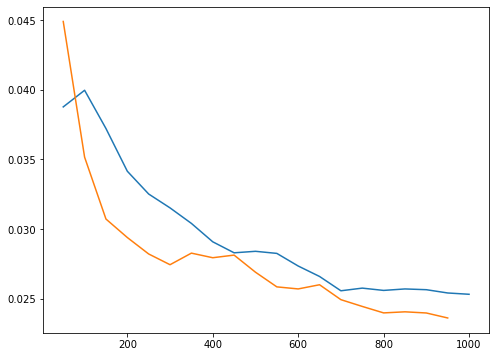

In [41]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,6))
xs, ys = zip(*mses)
xsrnd, ysrnd = zip(*random_mses)
ax.plot(xs, ys)
ax.plot(xsrnd, ysrnd)

### Evaluate

Evaluate RMSE of each model on our test set of 50 randomly selected points.

In [19]:
pred_Y, pred_Y_variance = emukit_model_ed.predict(test_X)
mse_ed = np.sqrt(np.mean((pred_Y-test_Y)**2))
print('Experimental Design w/ Model Variance RMSE: ', mse_ed)

Experimental Design w/ Model Variance RMSE:  0.023506310390346074


In [20]:
pred_Y, pred_Y_variance = emukit_model_ird.predict(test_X)
mse_ird = np.sqrt(np.mean((pred_Y-test_Y)**2))
print('Experimental Design w/ Integrated Variance Reduction RMSE: ', mse_ird)

Experimental Design w/ Integrated Variance Reduction RMSE:  0.027631443315188294


In [21]:
pred_Y, pred_Y_variance = emukit_model_rnd.predict(test_X)
mse_rnd = np.sqrt(np.mean((pred_Y-test_Y)**2))
print('Random GP RMSE: ', mse_rnd)

Random GP RMSE:  0.026195549187910196


In [22]:
p = 1 - (mse_ed/mse_rnd)
f'Experimental Design w/ Model Variance is {p*100:.3f}% better than training on random points.'

'Experimental Design w/ Model Variance is 10.266% better than training on random points.'

In [23]:
p = 1 - (mse_ird/mse_rnd)
f'Experimental Design w/ Integrated Variance Reduction is {p*100:.3f}% better than training on random points.'

'Experimental Design w/ Integrated Variance Reduction is -5.481% better than training on random points.'

### Save Models

In [24]:
with open(f'experimental_design/models/model_variance_20_init_points_1000_loops_timeloss.pkl', "wb") as f:
     pickle.dump(emukit_model_ed, f)

with open(f'experimental_design/models/integrated_variance_reduction_20_init_points_1000_loops_timeloss.pkl', "wb") as f:
     pickle.dump(emukit_model_ird, f)
        
with open(f'experimental_design/models/1020_random_points_supervised_GP_timeloss.pkl', "wb") as f:
     pickle.dump(emukit_model_rnd, f)

In [26]:
with open(f'experimental_design/models/timeloss-1000-pts.pkl', 'wb') as f:
    pickle.dump((train_X, train_Y), f)